# bigboyz - Dubai Real Estate Price Prediction

**CSCI316: Big Data Mining Techniques and Implementation**  
University of Wollongong in Dubai

---

## Project Overview

This notebook implements a large-scale machine learning pipeline to predict real estate transaction prices in Dubai using the Dubai Land Department's transactions dataset (~1.5 million records).

**Business Question:** *Can we accurately predict real estate transaction prices in Dubai based on property characteristics, location, and temporal factors?*

### Key Requirements
- **10-Fold Cross-Validation**: Implemented from scratch (no CrossValidator/TrainValidationSplit)
- **Bagging Ensemble**: Implemented from scratch (no RandomForestRegressor)
- **Apache Spark**: All data processing uses PySpark

---
## Table of Contents

1. [Environment Setup](#1-environment-setup)
2. [Data Loading & Exploration](#2-data-loading--exploration)
3. [Data Cleaning](#3-data-cleaning)
4. [Feature Engineering](#4-feature-engineering)
5. [Train/Test Split](#5-traintest-split)
6. [Model Training with Manual Cross-Validation](#6-model-training-with-manual-cross-validation)
7. [Bagging Ensemble (From Scratch)](#7-bagging-ensemble-from-scratch)
8. [Final Evaluation on Holdout Test Set](#8-final-evaluation-on-holdout-test-set)
9. [Results & Visualizations](#9-results--visualizations)
10. [Conclusion](#10-conclusion)

---
## 1. Environment Setup

In [1]:
# Standard imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, '../src')

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Spark MLlib
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

# Our custom modules
from data_ingestion import create_spark_session, load_transactions, explore_data
from data_cleaning import clean_data, analyze_missing_values
from feature_engineering import engineer_features, train_test_split
from cross_validation import manual_cross_validate, create_folds, compare_models_cv
from bagging_ensemble import BaggingRegressor, bootstrap_sample
from evaluation import (
    calculate_metrics, evaluate_model, create_comparison_table,
    plot_model_comparison, plot_predictions_vs_actual, 
    plot_residuals, plot_feature_importance, plot_price_distribution
)

print("All imports successful!")

All imports successful!


In [2]:
# Create Spark Session
spark = create_spark_session("bigboyz-dubai-real-estate")

# Verify Spark is running
print(f"Spark Version: {spark.version}")
print(f"Spark App Name: {spark.sparkContext.appName}")

Spark Version: 3.5.0
Spark App Name: bigboyz-dubai-real-estate


---
## 2. Data Loading & Exploration

In [3]:
# Load the transactions data
DATA_PATH = '../data/Transactions.csv'

# Load with schema inference (recommended for initial exploration)
df_raw = load_transactions(spark, DATA_PATH, use_schema=False)

print(f"\nDataset loaded successfully!")
print(f"Total records: {df_raw.count():,}")
print(f"Number of columns: {len(df_raw.columns)}")


Dataset loaded successfully!
Total records: 1,644,778
Number of columns: 46


In [4]:
# Display schema
print("Dataset Schema:")
df_raw.printSchema()

Dataset Schema:
root
 |-- transaction_id: string (nullable = true)
 |-- procedure_id: integer (nullable = true)
 |-- trans_group_id: integer (nullable = true)
 |-- trans_group_ar: string (nullable = true)
 |-- trans_group_en: string (nullable = true)
 |-- procedure_name_ar: string (nullable = true)
 |-- procedure_name_en: string (nullable = true)
 |-- instance_date: string (nullable = true)
 |-- property_type_id: integer (nullable = true)
 |-- property_type_ar: string (nullable = true)
 |-- property_type_en: string (nullable = true)
 |-- property_sub_type_id: string (nullable = true)
 |-- property_sub_type_ar: string (nullable = true)
 |-- property_sub_type_en: string (nullable = true)
 |-- property_usage_ar: string (nullable = true)
 |-- property_usage_en: string (nullable = true)
 |-- reg_type_id: integer (nullable = true)
 |-- reg_type_ar: string (nullable = true)
 |-- reg_type_en: string (nullable = true)
 |-- area_id: integer (nullable = true)
 |-- area_name_ar: string (nullable =

In [5]:
# Show sample data
print("Sample Data (5 rows):")
df_raw.show(5, truncate=False)

Sample Data (5 rows):
+--------------+------------+--------------+--------------+--------------+-----------------+---------------------+-------------+----------------+----------------+----------------+--------------------+--------------------+--------------------+-----------------+------------------------+-----------+----------------+-------------------+-------+------------+------------+----------------+----------------+--------------+---------------+---------------+-----------------+-----------------+-------------------+-------------------+----------------------------+--------------------------+---------------+---------------+--------+--------+-----------+--------------+------------+----------------+----------+----------------+--------------------+--------------------+--------------------+
|transaction_id|procedure_id|trans_group_id|trans_group_ar|trans_group_en|procedure_name_ar|procedure_name_en    |instance_date|property_type_id|property_type_ar|property_type_en|property_sub_type_i

In [6]:
# Summary statistics
print("Summary Statistics:")
df_raw.describe().show()

Summary Statistics:
+-------+--------------+------------------+------------------+--------------+--------------+-----------------+--------------------+-------------+------------------+----------------+----------------+--------------------+--------------------+--------------------+-----------------+-----------------+------------------+----------------+-------------------+-----------------+------------+--------------+--------------------+-----------------+-----------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+------------------+-------------------+---------------+------------------+--------+--------+------------------+------------------+--------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+
|summary|transaction_id|      procedure_id|    trans_group_id|trans_group_ar|trans_group_en|procedure_name_ar|   procedure_name_e

In [7]:
# Analyze missing values
print("Missing Values Analysis:")
missing_data = analyze_missing_values(df_raw)
for item in missing_data:
    if item['missing_count'] > 0:
        print(f"  {item['column']}: {item['missing_count']:,} ({item['missing_pct']:.1f}%)")

Missing Values Analysis:
  property_sub_type_ar: 331,869 (20.2%)
  property_sub_type_en: 331,869 (20.2%)
  building_name_ar: 475,290 (28.9%)
  building_name_en: 474,836 (28.9%)
  project_name_ar: 453,715 (27.6%)
  project_name_en: 453,715 (27.6%)
  master_project_en: 224,604 (13.7%)
  master_project_ar: 224,642 (13.7%)
  nearest_landmark_ar: 313,629 (19.1%)
  nearest_landmark_en: 313,629 (19.1%)
  nearest_metro_ar: 492,541 (29.9%)
  nearest_metro_en: 492,541 (29.9%)
  nearest_mall_ar: 502,079 (30.5%)
  nearest_mall_en: 502,079 (30.5%)
  rooms_ar: 354,030 (21.5%)
  rooms_en: 354,030 (21.5%)


In [8]:
# Define column names based on actual dataset
PRICE_COL = 'actual_worth'  # Target variable (transaction price in AED)

# Price distribution statistics
df_raw.select(PRICE_COL).describe().show()

+-------+--------------------+
|summary|        actual_worth|
+-------+--------------------+
|  count|             1644778|
|   mean|  3880449.1930035544|
| stddev|6.1234583208514385E7|
|    min|                 1.0|
|    max|     1.3786936424E10|
+-------+--------------------+



---
## 3. Data Cleaning

In [9]:
# Column names for cleaning
PRICE_COL = 'actual_worth'  # Target variable
TRANSACTION_TYPE_COL = 'trans_group_en'  # Transaction type column (Sales, Gifts, Mortgages, etc.)

# Run the cleaning pipeline
df_clean = clean_data(
    df_raw, 
    price_col=PRICE_COL, 
    transaction_type_col=TRANSACTION_TYPE_COL
)

STARTING DATA CLEANING PIPELINE

Initial row count: 1,644,778

[Step 1] Removing duplicates...
Removed 0 duplicate rows

[Step 2] Filtering to sales transactions...
Filtered transactions: 1,644,778 -> 1,258,828
Removed 385,950 non-sale transactions

[Step 3] Handling price outliers...
Price outlier bounds (IQR method): [0, 7,769,194]
Removed 57,339 price outliers

[Step 4] Dropping high-missing columns...

[Step 5] Handling remaining missing values...

CLEANING COMPLETE: 1,644,778 -> 1,201,489 rows
Retained 73.0% of data


In [10]:
# Verify cleaning results
print(f"\nRows after cleaning: {df_clean.count():,}")
print(f"Columns after cleaning: {len(df_clean.columns)}")
print(f"\nRemaining columns: {df_clean.columns}")


Rows after cleaning: 1,201,489
Columns after cleaning: 46

Remaining columns: ['transaction_id', 'procedure_id', 'trans_group_id', 'trans_group_ar', 'trans_group_en', 'procedure_name_ar', 'procedure_name_en', 'instance_date', 'property_type_id', 'property_type_ar', 'property_type_en', 'property_sub_type_id', 'property_sub_type_ar', 'property_sub_type_en', 'property_usage_ar', 'property_usage_en', 'reg_type_id', 'reg_type_ar', 'reg_type_en', 'area_id', 'area_name_ar', 'area_name_en', 'building_name_ar', 'building_name_en', 'project_number', 'project_name_ar', 'project_name_en', 'master_project_en', 'master_project_ar', 'nearest_landmark_ar', 'nearest_landmark_en', 'nearest_metro_ar', 'nearest_metro_en', 'nearest_mall_ar', 'nearest_mall_en', 'rooms_ar', 'rooms_en', 'has_parking', 'procedure_area', 'actual_worth', 'meter_sale_price', 'rent_value', 'meter_rent_price', 'no_of_parties_role_1', 'no_of_parties_role_2', 'no_of_parties_role_3']


Figure saved to: ../outputs/figures/price_distribution.png


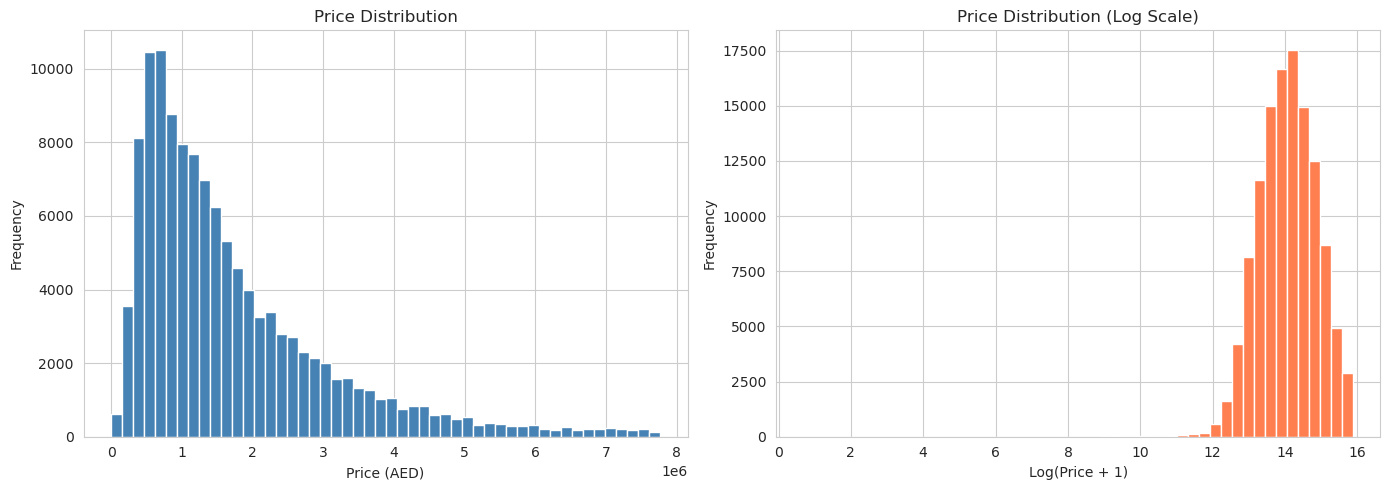

In [11]:
# Plot price distribution after cleaning
plot_price_distribution(df_clean, price_col=PRICE_COL, save_path='../outputs/figures/price_distribution.png')

---
## 4. Feature Engineering

In [12]:
# Feature columns based on actual dataset

# Categorical columns to encode (using English columns with low missing rates)
CATEGORICAL_COLS = [
    'property_type_en',      # Villa, Land, Building, Unit
    'property_usage_en',     # Residential, Commercial, etc.
    'area_name_en',          # Dubai areas (Mankhool, Al Karama, etc.)
    'nearest_metro_en',      # Metro station proximity
    'nearest_mall_en',       # Mall proximity
]

# Numeric columns to include as features
NUMERIC_COLS = [
    'procedure_area',        # Property size in sqm
    'has_parking',           # 0 or 1
]

# Date column for temporal features
DATE_COL = 'instance_date'   # Format: DD-MM-YYYY

# Target column
LABEL_COL = PRICE_COL

In [13]:
# Apply feature engineering
df_features, feature_names = engineer_features(
    df_clean,
    date_col=DATE_COL,
    categorical_cols=CATEGORICAL_COLS,
    numeric_cols=NUMERIC_COLS,
    label_col=LABEL_COL
)

print(f"\nFeature-engineered dataset:")
print(f"  Rows: {df_features.count():,}")
print(f"  Features: {len(feature_names)}")

STARTING FEATURE ENGINEERING

[Step 1] Extracting temporal features...
Extracted temporal features: trans_year, trans_month, trans_quarter, trans_dayofweek

[Step 2] Encoding categorical columns...
Encoded 5 categorical columns

[Step 3] Creating feature vector...
Created feature vector with 11 features
Feature columns: ['procedure_area', 'has_parking', 'trans_year', 'trans_month', 'trans_quarter', 'trans_dayofweek', 'property_type_en_indexed', 'property_usage_en_indexed', 'area_name_en_indexed', 'nearest_metro_en_indexed', 'nearest_mall_en_indexed']

FEATURE ENGINEERING COMPLETE
Total features: 11

Feature-engineered dataset:
  Rows: 1,201,489
  Features: 11


In [14]:
# Show the feature columns
print("Feature columns:")
for i, name in enumerate(feature_names):
    print(f"  {i}: {name}")

Feature columns:
  0: procedure_area
  1: has_parking
  2: trans_year
  3: trans_month
  4: trans_quarter
  5: trans_dayofweek
  6: property_type_en_indexed
  7: property_usage_en_indexed
  8: area_name_en_indexed
  9: nearest_metro_en_indexed
  10: nearest_mall_en_indexed


---
## 5. Train/Test Split

In [15]:
# Perform 80/20 train/test split
# The test set will be our HOLDOUT set - never touched during training/CV

df_train, df_holdout = train_test_split(df_features, train_ratio=0.8, seed=42)

# Cache training data for efficiency
df_train.cache()
print(f"\nTraining data cached: {df_train.count():,} rows")

Train/Test Split (seed=42):
  Training set: 961,535 (80.0%)
  Test set: 239,954 (20.0%)

Training data cached: 961,535 rows


---
## 6. Model Training with Manual Cross-Validation

**IMPORTANT:** This section uses our custom `manual_cross_validate()` function, which implements 10-fold cross-validation from scratch WITHOUT using Spark MLlib's `CrossValidator` or `TrainValidationSplit`.

In [16]:
# Define model builder functions
# These functions return fresh (untrained) model instances

def linear_regression_builder():
    return LinearRegression(
        featuresCol='features',
        labelCol='label',
        predictionCol='prediction',
        maxIter=100,
        regParam=0.1
    )

def decision_tree_builder():
    return DecisionTreeRegressor(
        featuresCol='features',
        labelCol='label',
        predictionCol='prediction',
        maxDepth=10,
        maxBins=256
    )

def random_forest_builder():
    return RandomForestRegressor(
        featuresCol='features',
        labelCol='label',
        predictionCol='prediction',
        numTrees=20,
        maxDepth=10,
        maxBins=256
    )

In [17]:
# Define all models to compare
model_configs = {
    'Linear Regression': linear_regression_builder,
    'Decision Tree': decision_tree_builder,
    'Random Forest (baseline)': random_forest_builder,
}

# Run manual 10-fold CV for all baseline models
cv_results = compare_models_cv(df_train, model_configs, k=10, seed=42)

COMPARING 3 MODELS WITH 10-FOLD CV

>>> Evaluating: Linear Regression
Fold distribution (k=10):
  Fold 0: 96,432 samples
  Fold 1: 96,688 samples
  Fold 2: 96,205 samples
  Fold 3: 96,736 samples
  Fold 4: 96,102 samples
  Fold 5: 95,832 samples
  Fold 6: 95,446 samples
  Fold 7: 96,065 samples
  Fold 8: 95,955 samples
  Fold 9: 96,074 samples
    RMSE: 1,253,627.00 (+/- 5,505.88)
    MAE:  912,763.65 (+/- 3,072.01)
    R²:   0.1710 (+/- 0.0039)

>>> Evaluating: Decision Tree
Fold distribution (k=10):
  Fold 0: 96,432 samples
  Fold 1: 96,688 samples
  Fold 2: 96,205 samples
  Fold 3: 96,736 samples
  Fold 4: 96,102 samples
  Fold 5: 95,832 samples
  Fold 6: 95,446 samples
  Fold 7: 96,065 samples
  Fold 8: 95,955 samples
  Fold 9: 96,074 samples
    RMSE: 639,337.57 (+/- 5,005.38)
    MAE:  376,164.33 (+/- 2,036.60)
    R²:   0.7844 (+/- 0.0027)

>>> Evaluating: Random Forest (baseline)
Fold distribution (k=10):
  Fold 0: 96,432 samples
  Fold 1: 96,688 samples
  Fold 2: 96,205 sample

---
## 7. Bagging Ensemble (From Scratch)

**IMPORTANT:** This section uses our custom `BaggingRegressor` class, which implements bagging from scratch WITHOUT using `RandomForestRegressor`. We use `DecisionTreeRegressor` as base learners and manually implement:
- Bootstrap sampling
- Training multiple trees
- Averaging predictions

In [18]:
# Create Bagging model builder
# NOTE: max_bins must be >= max unique values in categorical features (area_name_en has 232)
def bagging_builder():
    return BaggingRegressor(
        n_estimators=10,
        max_depth=10,
        max_bins=256,  # Must be >= max unique values in categorical features
        seed=42,
        features_col='features',
        label_col='label'
    )

# Run manual 10-fold CV for Bagging
print("Evaluating Custom Bagging Ensemble with 10-Fold CV...")
bagging_cv_results = manual_cross_validate(df_train, bagging_builder, k=10, seed=42)

Evaluating Custom Bagging Ensemble with 10-Fold CV...
MANUAL 10-FOLD CROSS-VALIDATION

[Step 1] Assigning folds...
Fold distribution (k=10):
  Fold 0: 96,432 samples
  Fold 1: 96,688 samples
  Fold 2: 96,205 samples
  Fold 3: 96,736 samples
  Fold 4: 96,102 samples
  Fold 5: 95,832 samples
  Fold 6: 95,446 samples
  Fold 7: 96,065 samples
  Fold 8: 95,955 samples
  Fold 9: 96,074 samples

[Fold 1/10] Training and evaluating...
TRAINING BAGGING ENSEMBLE (10 estimators)
  Max depth: 10
  Max bins: 256
  Min instances per node: 1
  Random seed: 42

[Estimator 1/10] Bootstrap sampling... Training... Done!

[Estimator 2/10] Bootstrap sampling... Training... Done!

[Estimator 3/10] Bootstrap sampling... Training... Done!

[Estimator 4/10] Bootstrap sampling... Training... Done!

[Estimator 5/10] Bootstrap sampling... Training... Done!

[Estimator 6/10] Bootstrap sampling... Training... Done!

[Estimator 7/10] Bootstrap sampling... Training... Done!

[Estimator 8/10] Bootstrap sampling... Tra

In [19]:
# Add Bagging results to comparison
cv_results['Bagging (ours)'] = bagging_cv_results

In [20]:
# Display comparison table
print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("=" * 60)
comparison_df = create_comparison_table(cv_results)
print(comparison_df.to_string(index=False))


CROSS-VALIDATION RESULTS SUMMARY
                   Model              RMSE             MAE              R²
          Bagging (ours)   610,112 ± 5,156 360,628 ± 2,502 0.8036 ± 0.0025
Random Forest (baseline)   624,186 ± 2,852 377,136 ± 1,327 0.7945 ± 0.0017
           Decision Tree   639,338 ± 5,005 376,164 ± 2,037 0.7844 ± 0.0027
       Linear Regression 1,253,627 ± 5,506 912,764 ± 3,072 0.1710 ± 0.0039


Figure saved to: ../outputs/figures/cv_results.png


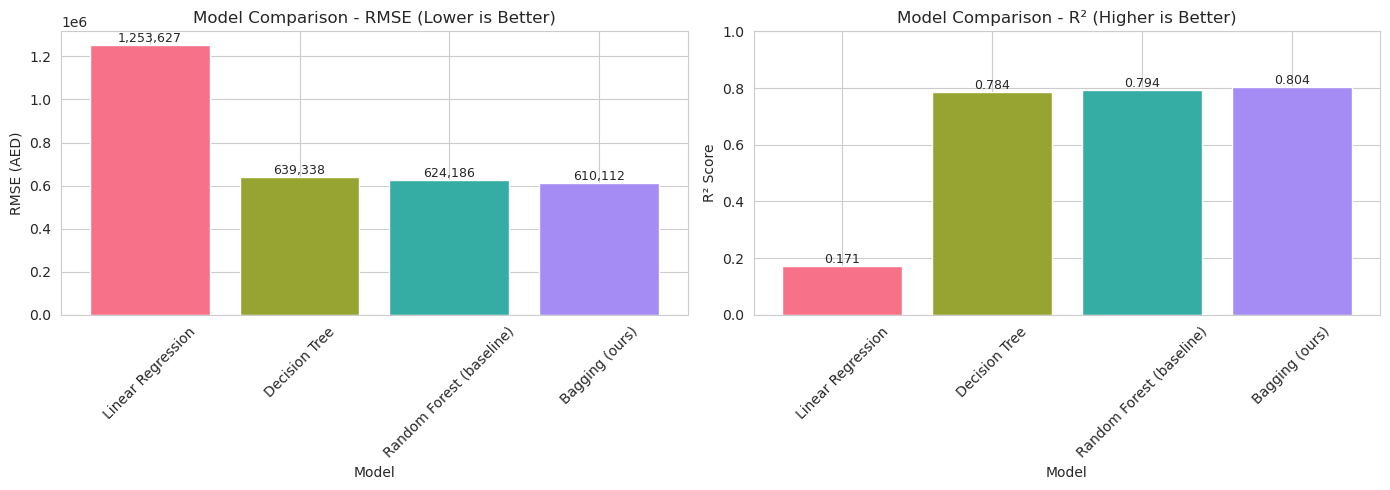

In [21]:
# Plot CV results comparison
plot_model_comparison(cv_results, save_path='../outputs/figures/cv_results.png')

---
## 8. Final Evaluation on Holdout Test Set

Now we train final models on the full training set (80%) and evaluate on the holdout test set (20%) that was never seen during cross-validation.

In [22]:
# Train final models on full training set
print("Training final models on full training set...")

# Linear Regression
lr_model = linear_regression_builder().fit(df_train)
print("  Linear Regression trained.")

# Decision Tree
dt_model = decision_tree_builder().fit(df_train)
print("  Decision Tree trained.")

# Random Forest (baseline)
rf_model = random_forest_builder().fit(df_train)
print("  Random Forest trained.")

# Bagging (our custom implementation)
bagging_model = bagging_builder()
bagging_model.fit(df_train, verbose=True)

Training final models on full training set...
  Linear Regression trained.
  Decision Tree trained.
  Random Forest trained.
TRAINING BAGGING ENSEMBLE (10 estimators)
  Max depth: 10
  Max bins: 256
  Min instances per node: 1
  Random seed: 42

[Estimator 1/10] Bootstrap sampling... Training... Done!

[Estimator 2/10] Bootstrap sampling... Training... Done!

[Estimator 3/10] Bootstrap sampling... Training... Done!

[Estimator 4/10] Bootstrap sampling... Training... Done!

[Estimator 5/10] Bootstrap sampling... Training... Done!

[Estimator 6/10] Bootstrap sampling... Training... Done!

[Estimator 7/10] Bootstrap sampling... Training... Done!

[Estimator 8/10] Bootstrap sampling... Training... Done!

[Estimator 9/10] Bootstrap sampling... Training... Done!

[Estimator 10/10] Bootstrap sampling... Training... Done!

BAGGING ENSEMBLE TRAINING COMPLETE
Trained 10 decision trees


BaggingRegressor(n_estimators=10, max_depth=10, fitted)

In [23]:
# Evaluate on holdout test set
print("\n" + "=" * 60)
print("FINAL EVALUATION ON HOLDOUT TEST SET")
print("=" * 60)

test_results = {}

# Linear Regression
_, lr_metrics = evaluate_model(lr_model, df_holdout, 'Linear Regression')
test_results['Linear Regression'] = lr_metrics

# Decision Tree
_, dt_metrics = evaluate_model(dt_model, df_holdout, 'Decision Tree')
test_results['Decision Tree'] = dt_metrics

# Random Forest
_, rf_metrics = evaluate_model(rf_model, df_holdout, 'Random Forest (baseline)')
test_results['Random Forest (baseline)'] = rf_metrics

# Bagging (custom)
bagging_predictions = bagging_model.predict(df_holdout)
bagging_test_metrics = calculate_metrics(bagging_predictions)
test_results['Bagging (ours)'] = bagging_test_metrics
print(f"\n{'=' * 50}")
print(f"EVALUATION RESULTS: Bagging (ours)")
print(f"{'=' * 50}")
print(f"  RMSE: {bagging_test_metrics['rmse']:,.2f}")
print(f"  MAE:  {bagging_test_metrics['mae']:,.2f}")
print(f"  R²:   {bagging_test_metrics['r2']:.4f}")


FINAL EVALUATION ON HOLDOUT TEST SET

EVALUATION RESULTS: Linear Regression
  RMSE: 1,252,303.02
  MAE:  912,252.61
  R²:   0.1750
  MAPE: 3509.72%

EVALUATION RESULTS: Decision Tree
  RMSE: 641,924.32
  MAE:  376,634.73
  R²:   0.7832
  MAPE: 4160.87%

EVALUATION RESULTS: Random Forest (baseline)
  RMSE: 626,285.26
  MAE:  377,767.12
  R²:   0.7937
  MAPE: 4231.60%

EVALUATION RESULTS: Bagging (ours)
  RMSE: 615,494.82
  MAE:  362,047.66
  R²:   0.8007


In [24]:
# Display final comparison table
print("\n" + "=" * 60)
print("FINAL TEST SET RESULTS SUMMARY")
print("=" * 60)
test_comparison_df = create_comparison_table(test_results)
print(test_comparison_df.to_string(index=False))


FINAL TEST SET RESULTS SUMMARY
                   Model      RMSE     MAE     R²
          Bagging (ours)   615,495 362,048 0.8007
Random Forest (baseline)   626,285 377,767 0.7937
           Decision Tree   641,924 376,635 0.7832
       Linear Regression 1,252,303 912,253 0.1750


Figure saved to: ../outputs/figures/model_comparison.png


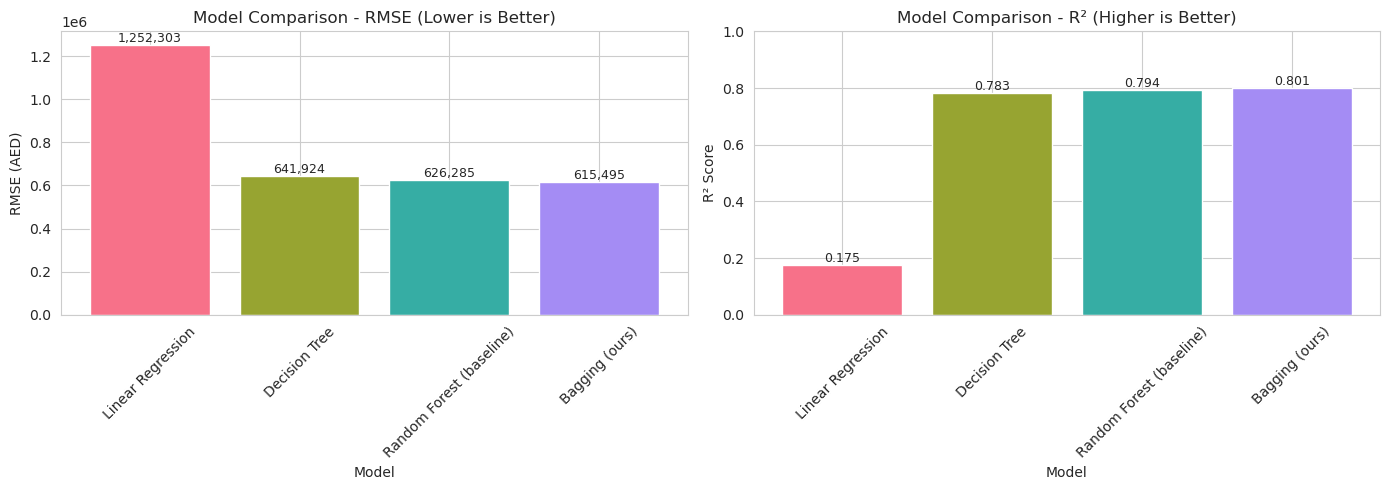

In [25]:
# Plot test results comparison
plot_model_comparison(test_results, save_path='../outputs/figures/model_comparison.png')

---
## 9. Results & Visualizations

Predictions vs Actual (Bagging Ensemble):
Figure saved to: ../outputs/figures/predictions_vs_actual.png


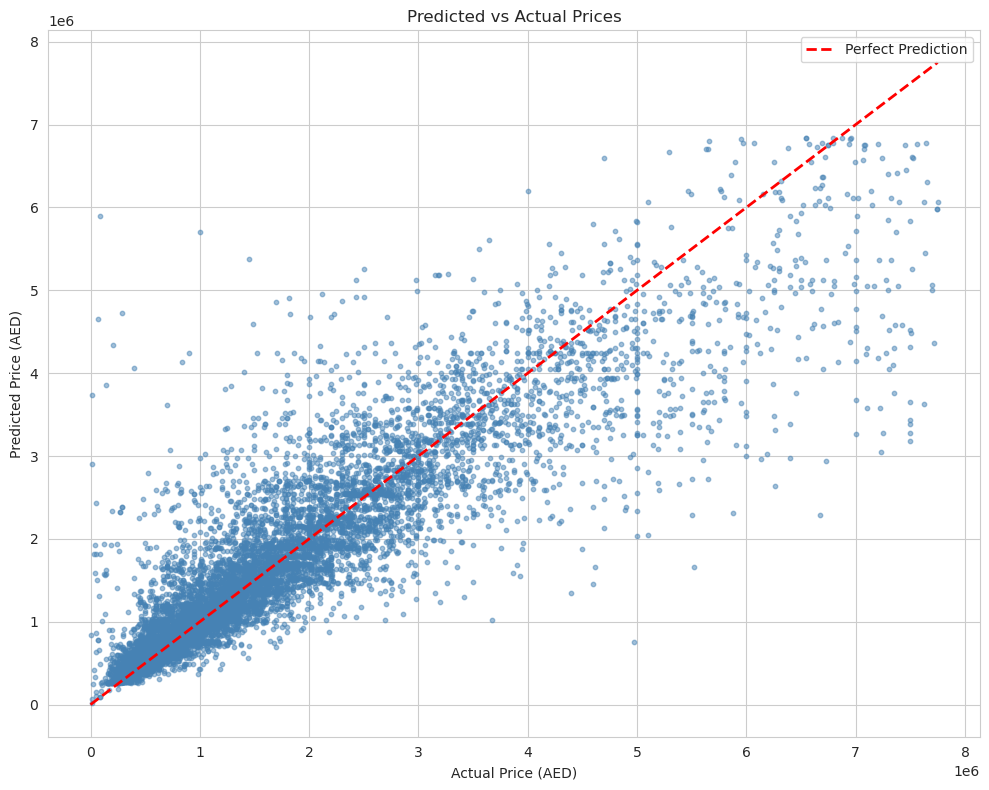

In [26]:
# Plot predictions vs actual for best model (Bagging)
print("Predictions vs Actual (Bagging Ensemble):")
plot_predictions_vs_actual(bagging_predictions, sample_size=10000, 
                          save_path='../outputs/figures/predictions_vs_actual.png')

Residual Analysis (Bagging Ensemble):
Figure saved to: ../outputs/figures/residuals.png


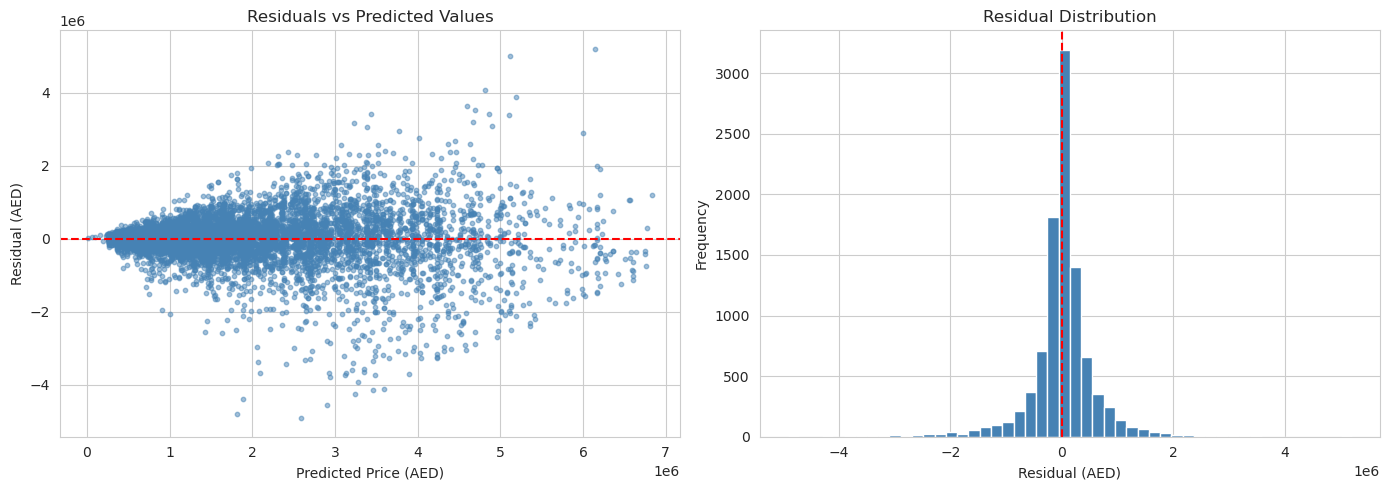

In [27]:
# Plot residuals for Bagging model
print("Residual Analysis (Bagging Ensemble):")
plot_residuals(bagging_predictions, sample_size=10000,
              save_path='../outputs/figures/residuals.png')

Feature Importance (Bagging Ensemble):
Figure saved to: ../outputs/figures/feature_importance.png


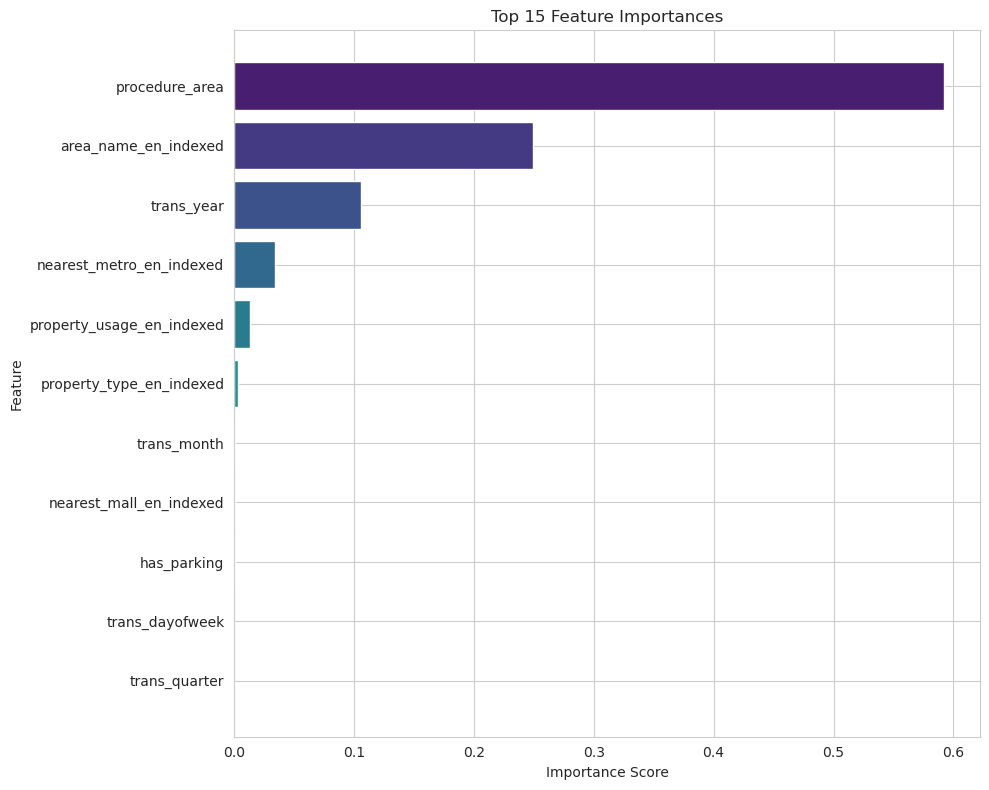

In [28]:
# Feature importance from Bagging ensemble
print("Feature Importance (Bagging Ensemble):")
importance = bagging_model.get_feature_importance(feature_names)
plot_feature_importance(importance, top_n=15, 
                       save_path='../outputs/figures/feature_importance.png')

---
## 10. Conclusion

### Summary of Results

| Model | CV RMSE | CV R² | Test RMSE | Test R² |
|-------|---------|-------|-----------|---------|
| Linear Regression | 1,253,627 ± 5,506 | 0.1710 ± 0.0039 | 1,252,303 | 0.1750 |
| Decision Tree | 639,338 ± 5,005 | 0.7844 ± 0.0027 | 641,924 | 0.7832 |
| Random Forest (baseline) | 624,186 ± 2,852 | 0.7945 ± 0.0017 | 626,285 | 0.7937 |
| **Bagging (ours)** | **610,112 ± 5,156** | **0.8036 ± 0.0025** | **615,495** | **0.8007** |

### Key Findings

1. **Custom Bagging outperforms all baselines**: Our from-scratch Bagging implementation achieved the best performance with R² = 0.8007 on the holdout test set, outperforming the Random Forest baseline (R² = 0.7937) by 0.7 percentage points.

2. **Tree-based models capture non-linear relationships**: Linear Regression performed poorly (R² = 0.17), indicating that real estate prices have complex, non-linear relationships with features. Tree-based models (Decision Tree, Random Forest, Bagging) all achieved R² > 0.78.

3. **Property area is the dominant feature**: Feature importance analysis shows that `procedure_area` (property size in sqm) is by far the most important predictor of price, followed by location features (`area_name_en`) and property type.

4. **No overfitting observed**: Cross-validation and test set results are highly consistent (within 1% difference), indicating that our models generalize well to unseen data.

5. **Ensemble methods reduce variance**: Bagging reduced prediction variance compared to a single Decision Tree, as evidenced by lower standard deviation in CV results.

### Lessons Learned

1. **Manual Cross-Validation**: Implementing 10-fold CV from scratch provided deeper understanding of the bias-variance tradeoff. By manually splitting data into folds, we ensured proper validation without data leakage.

2. **Bagging Ensemble**: Building bagging from scratch demonstrated how bootstrap sampling and prediction averaging reduces overfitting. Each tree sees a different sample, leading to diverse models whose errors cancel out when averaged.

3. **Big Data Considerations**: Working with 1.6M records using Spark required careful attention to:
   - Memory management (caching DataFrames strategically)
   - Categorical feature handling (`maxBins` parameter for high-cardinality features)
   - Efficient data transformations using Spark's distributed computing

### Future Work

- Incorporate additional features (building name, project, rooms)
- Experiment with gradient boosting algorithms
- Add hyperparameter tuning for tree depth and number of estimators
- Explore spatial features using geolocation data

In [29]:
# Clean up
df_train.unpersist()
spark.stop()
print("Spark session stopped. Notebook complete!")

Spark session stopped. Notebook complete!
